# Structural Analysis

or **Spatial Modeling**, or **Variography**

## Available Variogram Models

### Spherical 

Spherical model defined by an actual *range* a and positive variance contribution or *sill* value c

$$\gamma(h)=c\cdot \text{Sph}\left(\frac{h}{a}\right)= 
\begin{cases}
c \cdot \left[1.5\frac{h}{a}-0.5{\left(\frac{h}{a}\right)}^{3}\right], & \text{if } h\leq a \\
a, & \text{if } h\geq a
\end{cases}
$$

### Exponential

Exponential mode defined by an effective range a (integral range a/3) and positive variance contribution value c.

$$\gamma(h)=c \cdot \text{Exp}{\left(\frac{h}{c}\right)}=c\cdot \left[1-\exp\left(-\frac{3h}{a}\right)\right]$$

### Gaussian

Gaussian model defined by an effective range a and positive variance contribution value c.

$$\gamma(h)=c \cdot \left[1-\exp {\left(-\frac{{3h}^{2}}{{a}^{2}}\right)}\right]$$

### Power

Power model defined by a power $0<\omega<2$ and positive slope c.

$$\gamma(h)=c \cdot {h}^{\omega}$$

The distance h may be anisotropic in 2D or 3D.

### Hole effect

Hole effect model defined by a length a to the first peak (size of the underlying cyclic features) and positive variance contribution value c.

$$\gamma(h)=c \cdot \left[1.0-\cos\left(\frac{h}{a}\cdot \pi\right)\right]$$

To be a legitimate positive definite variogram model, the hole effect model may only be applied in one direction; that is, the variogram specified by the direction of hole effect, the range parameter in that direction, and very large range parameters in the two other directions, say, 1.0e21.

Although not allowed for in the parameter file, a dampened hole effect model is also coded in the cova3 subroutine. The dampened hole effect model is:

$$\gamma(h)=c\cdot \left[1.0-\exp{\left(-\frac{-3\cdot h}{d}\right)}\cdot \cos{\left(\frac{h}{a}\cdot \pi\right)}\right]$$

where d is distance at which 95% of the hole effect is dampened out(the variogram magnitude of the periodic component is then 5% of c)

## Fiting a variogram model

### 1. Fitting the behavior at the origin

<img src="img\behavior_near_origin.png", width=400>


### 2. Modeling the Continuous Component

## GUI for Variography

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook
import variogram_model as vm
from gamv_yuhao import Gamv
# import IPython widgets
from ipywidgets import *
import ipywidgets as widgets
from traitlets import link
from IPython.display import display

In [2]:
gamv = Gamv("testData/xihuSmall_sparse_gamv.par")
gamv.read_data()
gamv.gamv()
# fig, axes = data_analysis.graph()

gamv_yuhao.py:289: RuntimeWarning: invalid value encountered in true_divide
  self.gam /= self.npair
gamv_yuhao.py:294: RuntimeWarning: invalid value encountered in true_divide
  self.distance /= self.npair
gamv_yuhao.py:295: RuntimeWarning: invalid value encountered in true_divide
  self.tm /= self.npair
gamv_yuhao.py:296: RuntimeWarning: invalid value encountered in true_divide
  self.hm /= self.npair


In [3]:
plot_dropdown = widgets.Dropdown(
    options={i+1: i for i in xrange(gamv.ndir)},
    value = 0,
    description="Plot",
)

def plot(change):
    i = plot_dropdown.value
    abscissa = np.arange(0, gamv.nlag+1, 1.0)
    abscissa *= gamv.xlag
    ordinate = np.insert(gamv.gam[i][2:], 0, None)
    ax.cla()
    ax.scatter(abscissa, ordinate, color='r')
    ax.set_title(r"Azimuth: {}$^\circ$({}$^\circ$), ".format(
        gamv.azm[i], gamv.atol[i]) +
                 r"Dip: {}$^\circ$({}$^\circ$)".format(
                     gamv.dip[i], gamv.dtol[i]))
    ax.set_ylim(bottom=0)
    ax.set_xlim(left=0)
    ax.grid()

plot_dropdown.observe(plot, names="value")

plot_button = widgets.Button(
    button_style='primary',
    description='Plot',
    value=False,
)
plot_button.on_click(plot)

num_struct_slider = widgets.IntSlider(
    value=1,
    min=1,
    max=3,
    step=1,
    description='Structs:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
#     width='300px'
)
def num_on_change(change):
    index = change['new'] - 1
    for i, item in enumerate(struct_box.children):
        if i <= index:
            item.layout.visibility=''
        else:
            item.layout.visibility='hidden'
            item.children[3].value = 0
    
    
num_struct_slider.observe(num_on_change, names='value')

main_box = HBox((plot_dropdown, plot_button, num_struct_slider))

function_dict = {
    'Spherical': np.vectorize(vm.spherical),
    'Exponential': np.vectorize(vm.exponential),
    'Gaussian': np.vectorize(vm.gaussian)
}

def plot_fit(change):
    func = function_dict[type_1_dropdown.value]
    abscissa = np.arange(0, (gamv.nlag+4)*gamv.xlag, gamv.xlag/10)
    crange = range_1_text.value
    sill = sill_1_text.value
    nugget = nugget_effect_text.value
    if crange != 0 and sill != 0:
        ordinate = func(abscissa, sill, crange) + nugget
    else:
        ordinate = np.zeros(abscissa.shape) + nugget   
    if len(ax.lines) != 0:
        del ax.lines[-1]
    ax.plot(abscissa, ordinate, color='blue')
    plt.draw()

nugget_effect_text = widgets.FloatText(
    value=0,
    description='Nugget: '
)
nugget_effect_text.observe(plot_fit, names="value")
############################################
label_1 = widgets.HTML(
    value="<b>Structure 1:<b>"
)

type_1_dropdown = widgets.Dropdown(
    options=['Spherical', 'Exponential', 'Gaussian'],
    value = 'Spherical',
    description="Type: ",
)
type_1_dropdown.observe(plot_fit, names="value")

sill_1_text = widgets.FloatText(
    value=1,
    description='Sill (Contribution): '
)
sill_1_text.observe(plot_fit, names="value")
    
range_1_text = widgets.FloatSlider(
    value=0.0,
    min=0.0,
    max=(gamv.nlag+1) * gamv.xlag,
    step=0.1,
    description='Range:',
)
range_1_text.observe(plot_fit, names="value")

struct_1 = VBox((label_1, type_1_dropdown, sill_1_text, range_1_text))
############################################
label_2 = widgets.HTML(
    value="<b>Structure 2:<b>"
)

type_2_dropdown = widgets.Dropdown(
    options=['Spherical', 'Exponential', 'Gaussian'],
    value = 'Spherical',
    description="Type: ",
)
type_2_dropdown.observe(plot_fit, names="value")

sill_2_text = widgets.FloatText(
    value=1,
    description='Sill (Contribution): '
)
sill_2_text.observe(plot_fit, names="value")
    
range_2_text = widgets.FloatSlider(
    value=0.0,
    min=0.0,
    max=(gamv.nlag+1) * gamv.xlag,
    step=0.1,
    description='Range:',
)
range_2_text.observe(plot_fit, names="value")

struct_2 = VBox((label_2, type_2_dropdown, sill_2_text, range_2_text))
struct_2.layout.visibility='hidden'
############################################
label_3 = widgets.HTML(
    value="<b>Structure 3:<b>"
)

type_3_dropdown = widgets.Dropdown(
    options=['Spherical', 'Exponential', 'Gaussian'],
    value = 'Spherical',
    description="Type: ",
)
type_3_dropdown.observe(plot_fit, names="value")

sill_3_text = widgets.FloatText(
    value=1,
    description='Sill (Contribution): '
)
sill_3_text.observe(plot_fit, names="value")
    
range_3_text = widgets.FloatSlider(
    value=0.0,
    min=0.0,
    max=(gamv.nlag+1) * gamv.xlag,
    step=0.1,
    description='Range:',
)
range_3_text.observe(plot_fit, names="value")

struct_3 = VBox((label_3, type_3_dropdown, sill_3_text, range_3_text))
struct_3.layout.visibility='hidden'
##############################
struct_box = HBox((struct_1, struct_2, struct_3))

<IPython.core.display.Javascript object>


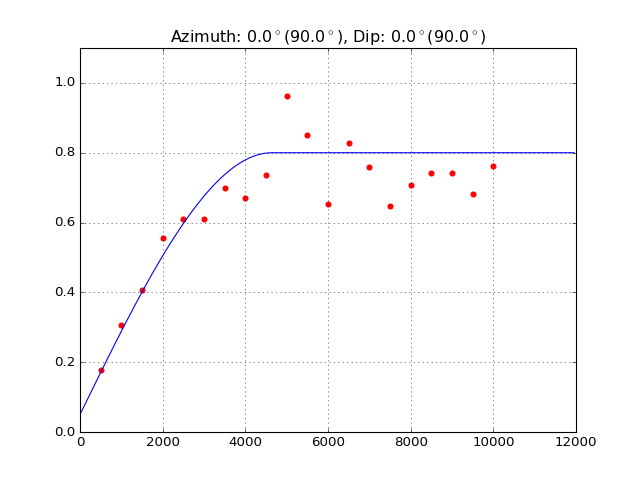

In [4]:
display(main_box, nugget_effect_text, struct_box)
fig, ax = plt.subplots()
# fig.tight_layout()